# PREPROCESSING GOOGLE EARTH PRO IMAGES FOR COLOMBIAN PÁRAMOS

In this notebook we will preprocess Google Earth Pro images for different Colombian páramos.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import packages.utils.get_path as path
import config.constants as const
ABSOLUTE_PATH = path.make_path()
INTERMEDIATE_DIR = path.make_path(ABSOLUTE_PATH , const.DATA_DIR,const.INTERMEDIATE_DIR)
RAW_IMAGES_DIR = path.make_path(ABSOLUTE_PATH , const.DATA_DIR,const.RAW_DIR, const.IMAGES_DIR)
NORMALIZED_IMAGES_DIR = path.make_path(ABSOLUTE_PATH , const.DATA_DIR,const.RAW_DIR, const.NORMALIZATION_DIR_IMAGES)

## Color and Contrast Correction:
Normalizing Brightness and Contrast for Consistent Illumination and Color

In [3]:
import cv2
import numpy as np

def calculate_average_brightness_contrast(image_list):
    brightness_values = []
    contrast_values = []

    for image_path in image_list:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if image is None:
            print(f"Failed to load image: {image_path}")
            continue

        # Calculate brightness as the average pixel value
        brightness = np.average(image)
        brightness_values.append(brightness)

        # Calculate contrast as the interquartile range of pixel values
        contrast = np.percentile(image, 75) - np.percentile(image, 25)
        contrast_values.append(contrast)

    # Calculate the average brightness and contrast
    average_brightness = np.average(brightness_values)
    average_contrast = np.average(contrast_values)

    return average_brightness, average_contrast

imgesbrutas = path.make_item_list(RAW_IMAGES_DIR)
# Use the function
average_brightness, average_contrast = calculate_average_brightness_contrast(imgesbrutas)

normalized_path = path.make_path(ABSOLUTE_PATH, const.DATA_DIR, const.PROCESSED_DIR, const.NORMALIZATION_DIR)
normalized_img_path = path.make_path(ABSOLUTE_PATH, const.DATA_DIR, const.RAW_DIR, const.NORMALIZATION_DIR_IMAGES)
np.save("{}/{}".format(normalized_path, const.AVG_BRIGTHNESS), average_brightness)
np.save("{}/{}".format(normalized_path, const.AVG_CONTRAST), average_contrast)

print(f"Average brightness: {average_brightness}")
print(f"Average contrast: {average_contrast}")


def normalize_with_brightness_contrast(image_list, average_brightness, average_contrast):
    for image_path in image_list:
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)

        if image is None:
            print(f"Failed to load image: {image_path}")
            continue

        # Limit contrast to avoid loss of detail
        #average_contrast = np.clip(average_contrast, 0.5, 1.5)

        # Normalize the image using the average brightness and contrast
        normalized_image = np.clip((image - np.average(image)) * (average_contrast / np.std(image)) + average_brightness, 0, 255).astype(np.uint8)

        # Save the normalized image
        normalized_image_path = image_path.replace(RAW_IMAGES_DIR, "{}".format(normalized_img_path))
        print(f"Saving normalized image to: {normalized_image_path}")
        cv2.imwrite(normalized_image_path, normalized_image)

normalize_with_brightness_contrast(imgesbrutas, average_brightness, average_contrast)

Failed to load image: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../data/0_raw/images/.gitkeep
Average brightness: 68.42029664638758
Average contrast: 31.0
Failed to load image: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../data/0_raw/images/.gitkeep
Saving normalized image to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../data/0_raw/normalized/Paramo_Rabanal_5_25_33_63N_73_33_3_39O_5087.jpg
Saving normalized image to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../data/0_raw/normalized/Paramo_Sumapaz_3_49_44_36N_74_24_35_44O_5087.jpg
Saving normalized image to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../data/0_raw/normalized/Paramo_Sumapaz_3_56_47_35N_74_19_5_15O_5087.jpg
Saving normalized image to: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../data/0_raw/normalized/Paramo_Sumapaz_4_10_35_53N_74_12_35_78O_5087.jpg
Saving normalized image to: /mnt/e/Code/Python/paramo-surveillance-colombia/noteb

## Data Augmentation:

We will use scripts from the [Data Augmentation](../scripts/aumentation.py) notebook to augment the images. We rotate the images by 90, 180 and 270 degrees, and flip them horizontally and vertically.

In [4]:
import subprocess

subprocess.call(["python", "../scripts/aumentation.py"])


Traceback (most recent call last):
  File "/mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../scripts/aumentation.py", line 92, in <module>
    main()
  File "/mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../scripts/aumentation.py", line 82, in main
    transform_image(
  File "/mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../scripts/aumentation.py", line 37, in transform_image
    transformed_img = img.transpose(transformation)
  File "/root/anaconda3/envs/preprocessing/lib/python3.10/site-packages/PIL/Image.py", line 2792, in transpose
    return self._new(self.im.transpose(method))
ValueError: No such transpose operation


1

## Split Data Images

We will split the images in subimages of 256x256 pixels to train the model. refer to the [Split Images](../scripts/split.py) notebook to split the images.

In [5]:
import subprocess
subprocess.call(["python", "../scripts/split.py", "--augment_data", "False"])

Image: /mnt/e/Code/Python/paramo-surveillance-colombia/data/0_raw/normalized/Paramo_Rabanal_5_25_33_63N_73_33_3_39O_5087.jpg
Image: /mnt/e/Code/Python/paramo-surveillance-colombia/data/0_raw/normalized/Paramo_Sumapaz_3_49_44_36N_74_24_35_44O_5087.jpg
Image: /mnt/e/Code/Python/paramo-surveillance-colombia/data/0_raw/normalized/Paramo_Sumapaz_3_56_47_35N_74_19_5_15O_5087.jpg
Image: /mnt/e/Code/Python/paramo-surveillance-colombia/data/0_raw/normalized/Paramo_Sumapaz_4_10_35_53N_74_12_35_78O_5087.jpg
Image: /mnt/e/Code/Python/paramo-surveillance-colombia/data/0_raw/normalized/Paramo_Sumapaz_4_21_43_45N_74_0_49_45O_5087.jpg
Image: /mnt/e/Code/Python/paramo-surveillance-colombia/data/0_raw/normalized/Paramo_Sumapaz_4_26_13_56N_74_11_26_93O_5087.jpg
Image: /mnt/e/Code/Python/paramo-surveillance-colombia/data/0_raw/normalized/Paramo_Sumapaz_4_3_52_56N_74_5_24_21O_5087.jpg
Image: /mnt/e/Code/Python/paramo-surveillance-colombia/data/0_raw/normalized/Paramo_Sumapaz_tiff_5087.jpg
Creating director

0

# Data Preparation

In [6]:

img_folders = path.make_directories_list(INTERMEDIATE_DIR)

normalized_folders = [x for x in img_folders if const.IMAGE_LABEL_END not in x ]
normalized_labels_folders = [x for x in img_folders if const.IMAGE_LABEL_END in x]

print(f"Total folders: {len(normalized_labels_folders)*2}")

label_paths = []
for label in normalized_labels_folders:
    label_paths += [os.path.join(label, filename) for filename in os.listdir(label) ]
print(f"Total labels: {len(label_paths)}")

rgb_paths = []
for rgb in normalized_folders:
    rgb_paths += [os.path.join(rgb, filename) for filename in os.listdir(rgb) ]
print(f"Total rgb: {len(rgb_paths)}")

# Normalizing Brightness and Contrast for Consistent Illumination and Color



Total folders: 16
Total labels: 4160
Total rgb: 4160


Image: /mnt/e/Code/Python/paramo-surveillance-colombia/notebooks/../data/1_intermediate/Paramo_Sumapaz_tiff_5087/Paramo_Sumapaz_tiff_5087_6_28.jpg


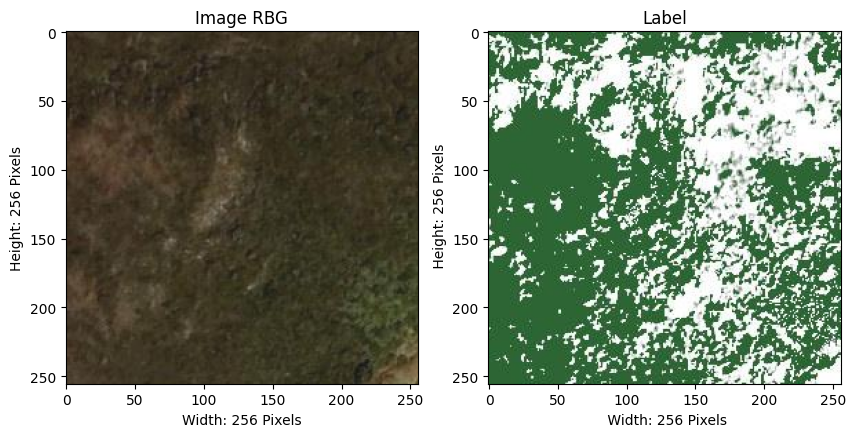

In [7]:
import matplotlib.pyplot as plt
import random

# Select a random image and its corresponding label
index = random.randint(0, len(rgb_paths) - 1)
rgb_path = rgb_paths[index]
label_path = label_paths[index]
print(f"{const.IMAGE_NAME}: {rgb_path}")
# Load the image and its corresponding label
rgb_image = plt.imread(rgb_path)
label_image = plt.imread(label_path)

# Display the image and its corresponding label
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(rgb_image)
ax[0].set_title(const.IMAGE_TITLE)
ax[0].set_xlabel(f'{const.WIDTH_NAME}: {rgb_image.shape[1]} {const.PIXEL_NAME}')
ax[0].set_ylabel(f'{const.HEIGHT_NAME}: {rgb_image.shape[0]} {const.PIXEL_NAME}')
ax[1].imshow(label_image, cmap=const.CMAP_GRAY)
ax[1].set_title(const.LABEL_TITLE)
ax[1].set_xlabel(f' {const.WIDTH_NAME}: {label_image.shape[1]} {const.PIXEL_NAME}')
ax[1].set_ylabel(f' {const.HEIGHT_NAME}: {label_image.shape[0]} {const.PIXEL_NAME}')
plt.show()

## Divide Data into Train , Test and Validation

In [8]:
from sklearn.model_selection import train_test_split

# Split the data into training (60%) and test (40%) sets
train_rgb_paths, test_rgb_paths, train_label_paths, test_label_paths = train_test_split(rgb_paths, label_paths, test_size=const.TEST_SIZE, random_state=const.RANDOM_STATE)

# Split the test set into two equal parts for evaluation and validation
eval_rgb_paths, val_rgb_paths, eval_label_paths, val_label_paths = train_test_split(test_rgb_paths, test_label_paths, test_size=const.EVALUATION_SIZE, random_state=const.RANDOM_STATE)


In [9]:

print(f"Total train: {len(train_rgb_paths)}")
print(f"Total val: {len(val_rgb_paths)}")
print(f"Total eval: {len(eval_rgb_paths)}")


Total train: 2496
Total val: 832
Total eval: 832


## Loading and Processing Image Data

In [10]:
from PIL import Image
import numpy as np
import cv2

def load_labels(paths):
    images = []
    for path in paths:
        with Image.open(path) as img:
            img = np.array(img)
            output_img = np.zeros(img.shape, dtype=np.uint8)  # Create a blank array for output image
            output_img[np.all(img >= [100, 120, 100], axis=-1)] = [255, 255, 255]  # Assign white to almost white pixels
            output_img[np.all(img < [100, 120, 100], axis=-1)] = [46, 101, 53]  # Assign the new color to all other pixels
            # Assign white to any remaining black pixels
            output_img[np.all(output_img == [0, 0, 0], axis=-1)] = [255, 255, 255]
            images.append(output_img)

    return np.array(images)

# imagenes etiquetadas en formato grayscale

def load_images(paths):
    images = []
    for path in paths:
        img = cv2.imread(path)
        images.append(img)
    return np.array(images)


### Load the images and save them to disk

In [11]:
data_train_path = path.make_path(ABSOLUTE_PATH, const.DATA_DIR, const.PROCESSED_DIR, const.TRAIN_DIR)
data_val_path = path.make_path(ABSOLUTE_PATH, const.DATA_DIR, const.PROCESSED_DIR, const.VALIDATION_DIR)
data_eval_path = path.make_path(ABSOLUTE_PATH, const.DATA_DIR, const.PROCESSED_DIR, const.EVALUATION_DIR)

In [12]:
import numpy as np

np.save("{}/{}".format(data_train_path, const.TRAIN_RGB_NPY), load_images(train_rgb_paths))
np.save("{}/{}".format(data_train_path, const.TRAIN_LABEL_NPY), load_labels(train_label_paths))
np.save("{}/{}".format(data_val_path, const.VAL_RGB_NPY), load_images(val_rgb_paths))
np.save("{}/{}".format(data_val_path, const.VAL_LABEL_NPY), load_labels(val_label_paths))
np.save("{}/{}".format(data_eval_path, const.EVAL_RGB_NPY), load_images(eval_rgb_paths))
np.save("{}/{}".format(data_eval_path, const.EVAL_LABEL_NPY), load_labels(eval_label_paths))

In [13]:
import numpy as np

train_rgb_images = np.load("{}/{}".format(data_train_path, const.TRAIN_RGB_NPY))
train_label_images = np.load("{}/{}".format(data_train_path, const.TRAIN_LABEL_NPY))

eval_rgb_images = np.load("{}/{}".format(data_val_path, const.VAL_RGB_NPY))
eval_label_images = np.load("{}/{}".format(data_val_path, const.VAL_LABEL_NPY))

val_rgb_images = np.load("{}/{}".format(data_eval_path, const.EVAL_RGB_NPY))
val_label_images = np.load("{}/{}".format(data_eval_path, const.EVAL_LABEL_NPY))


## Normalization

### Z-Score Normalization | $Z = \frac{X - \mu}{\sigma}$

In [14]:
normalized_path = path.make_path(ABSOLUTE_PATH, const.DATA_DIR, const.PROCESSED_DIR, const.NORMALIZATION_DIR)
mean = np.mean(train_rgb_images, axis=(0, 1, 2))  # Calculate the mean per channel
std = np.std(train_rgb_images, axis=(0, 1, 2))  # Calculate the standard deviation per channel

#save the mean and std as npy files
np.save("{}/{}".format(normalized_path, const.MEAN_NPY), mean)
np.save("{}/{}".format(normalized_path, const.STD_NPY), std)

### Min-Max Scaling Normalization | $X' = \frac{X - X_{min}}{X_{max} - X_{min}}$

In [15]:
min_val = np.min(train_rgb_images, axis=(0, 1, 2))  # Calculate the min per channel
max_val = np.max(train_rgb_images, axis=(0, 1, 2))  # Calculate the max per channel

#save the min and max as npy files
np.save("{}/{}".format(normalized_path, const.MIN_NPY), min_val)
np.save("{}/{}".format(normalized_path, const.MAX_NPY), max_val)


# Rendering Images to see the changes

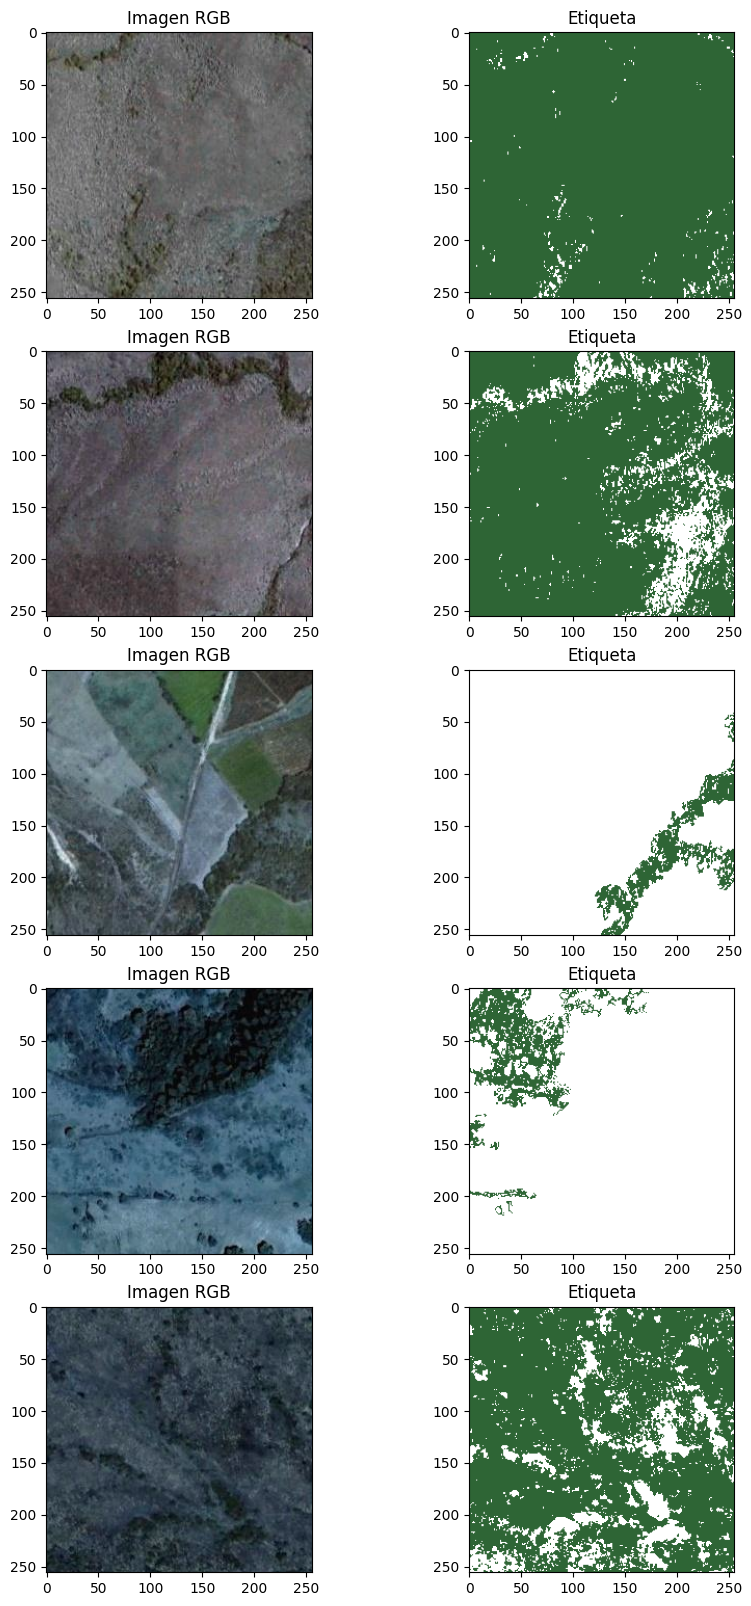

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Genera 5 índices aleatorios
random_indices = np.random.choice(len(train_rgb_images), 5, replace=False)

fig, ax = plt.subplots(5, 2, figsize=(10, 20))
for i, idx in enumerate(random_indices):
    ax[i, 0].imshow(train_rgb_images[idx])
    ax[i, 0].set_title('Imagen RGB')
    ax[i, 1].imshow(train_label_images[idx])
    ax[i, 1].set_title('Etiqueta')